In [21]:
import os
import math
import random

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

!pip install ipywidgets
from tqdm.auto import tqdm

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [22]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [23]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")

train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


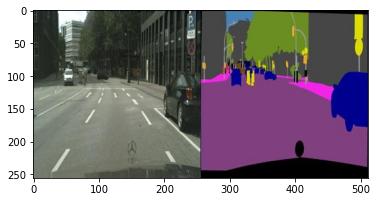

In [24]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)

In [25]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)


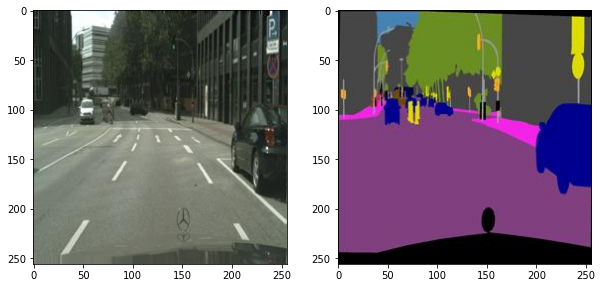

In [26]:
sample_image = np.array(sample_image)
print(sample_image.shape)

cityscape, label = split_image(sample_image)
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].imshow(cityscape)
axes[1].imshow(label)

In [27]:
"""
Preprocessing data before using KMeans for the search of clusters.
The idea is pretty simple, we want classes in place of RGB encoded values.
"""

num_items = 1000
color_array = np.random.choice(range(256), 3 * num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [28]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

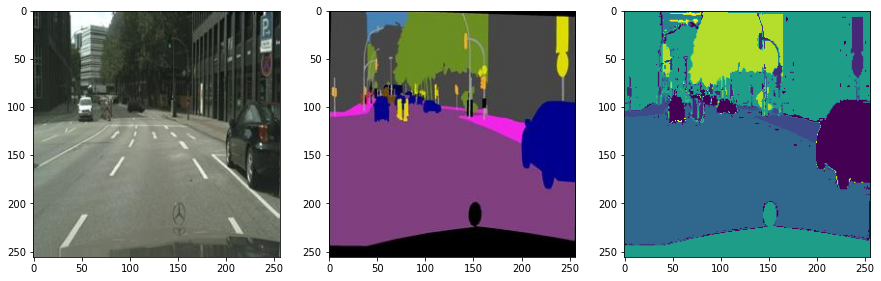

In [29]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [30]:
"""
After the KMeans, we have a 256x256 matrix where each cell has 
the id to the parent cluster.
"""

print(label_class[0].shape)
print(label_class[0])

(256,)
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


## 4. Define Dataset

In [31]:
class Configure(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean = (0.485, 0.456, 0.406), 
                std = (0.229, 0.224, 0.225)
            )
        ])
        return transform_ops(image)

In [32]:
dataset = Configure(train_dir, label_model)
print(f"There are {len(dataset)} samples!")

There are 2975 samples!


In [33]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = (3, 3), padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = (3, 3), padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.rel = nn.ReLU()
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        return self.rel(x)

In [35]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.bn1(self.up(x))
        return x

In [36]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels = 3, encoder_blocks = 4, multiplicity = 64, pool_stride = 2):
        super(UNet, self).__init__()
        self.initial_conv = DoubleConv(in_channels, multiplicity)
        self.encoder_blocks = encoder_blocks
        self.multiplicity = multiplicity
        self.pool_stride = pool_stride
        self.num_classes = num_classes
        
        self.maxpool = nn.MaxPool2d(2, stride = pool_stride)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.res = nn.ModuleList()
        self.final_conv = nn.Conv2d(multiplicity, num_classes, kernel_size = 1)

        skip_channels = [multiplicity]
        kernels = multiplicity
        for _ in range(self.encoder_blocks):
            self.downs.append(DoubleConv(kernels, kernels * 2))
            kernels *= 2
            skip_channels.append(kernels)

        for i in range(self.encoder_blocks):
            self.ups.append(UpConv(kernels, kernels // 2))
            self.res.append(DoubleConv(kernels // 2 + skip_channels[-(i + 2)], kernels // 2))
            kernels //= 2

    def forward(self, x):
        residuals = []
        x = self.initial_conv(x)
        residuals.append(x)

        for i, conv in enumerate(self.downs):
            x = self.maxpool(x) 
            x = conv(x)
            residuals.append(x)

        for up, res_block, skip in zip(self.ups, self.res, reversed(residuals[:-1])):
            x = up(x)
            x = torch.cat([skip, x], dim = 1)
            x = res_block(x)

        x = self.final_conv(x)
        return x

In [37]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [38]:
batch_size = 4
epochs = 10
lr = 0.01

dataset = Configure(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)
print(model)

UNet(
  (initial_conv): DoubleConv(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rel): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downs): ModuleList(
    (0): DoubleConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel): ReLU()
    )
    (1): DoubleConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [40]:
step_losses = []
epoch_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    for X, Y in tqdm(data_loader, leave = True):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    
    epoch_losses.append(epoch_loss / len(data_loader))

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


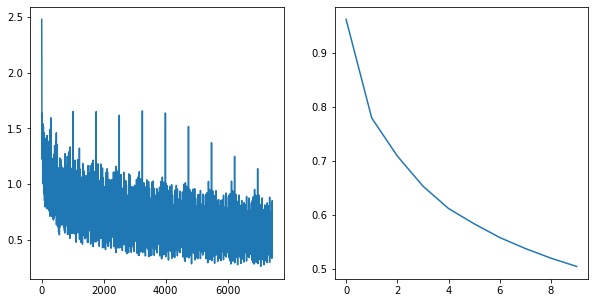

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [42]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

In [43]:
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [45]:
test_batch_size = 4
dataset = Configure(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

In [46]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim = 1)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])
torch.Size([4, 256, 256])


In [47]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), (1 / 0.229, 1 / 0.224, 1 / 0.225))
])

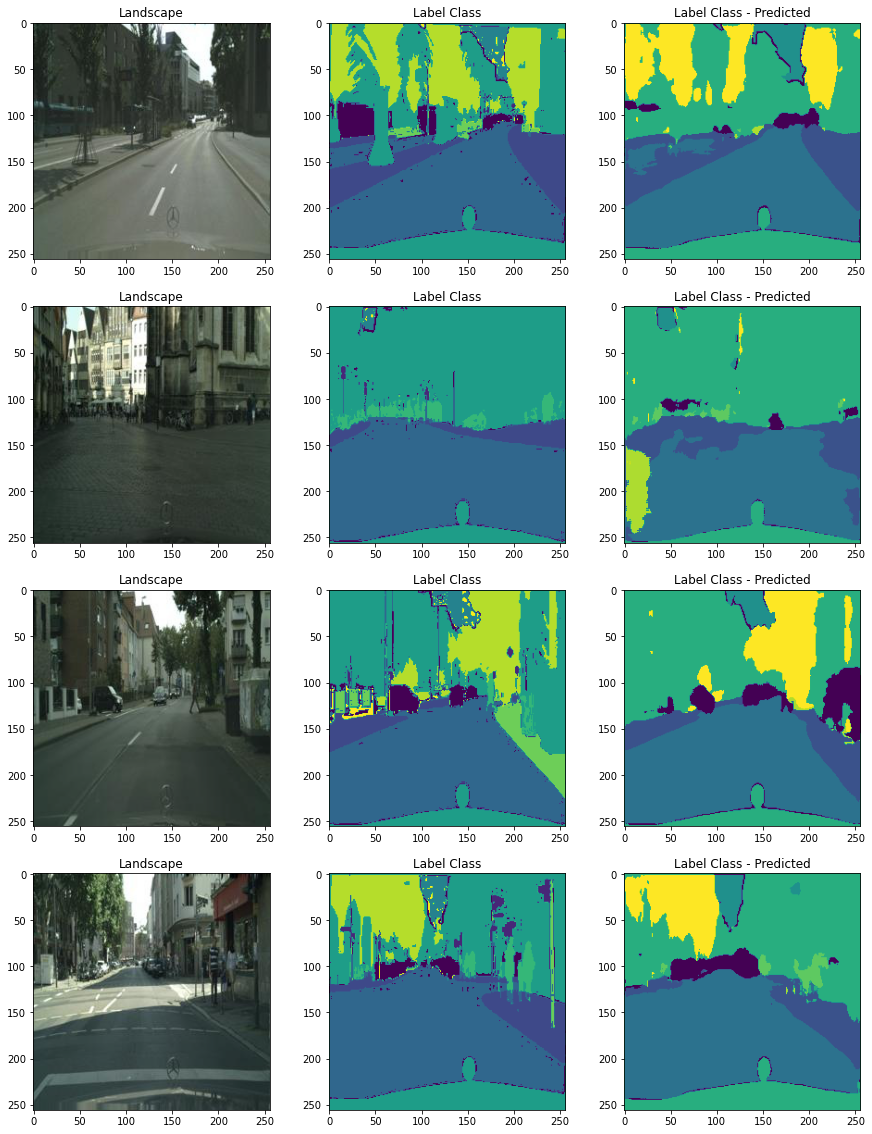

In [48]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3 * 5, test_batch_size * 5))

for i in range(test_batch_size):
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")